In [45]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_polylines(path_XYs, image_path):
    plt.figure()
    for path in path_XYs:
        for polyline in path:
            plt.plot(polyline[:, 0], polyline[:, 1])
    plt.gca().invert_yaxis()  # Optional: Invert y-axis if needed
    plt.axis('off')         # Equal scaling of axes
    plt.savefig(image_path)
    plt.close()

# Example usage
csv_path = r'./isolated.csv'
image_path = 'polylines_image.png'

path_XYs = read_csv(csv_path)
plot_polylines(path_XYs, image_path)

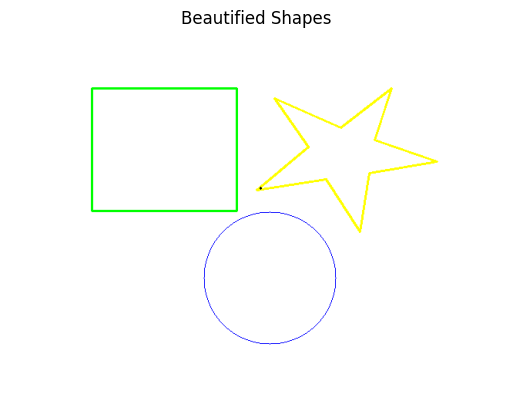

In [46]:
import cv2
import numpy as np

def detect_and_redraw_shapes(image_path, accuracy_threshold=0.03, match_threshold=0.8, proximity_threshold=10):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Create a blank image with white background
    blank_image = np.ones_like(image) * 255

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours and hierarchy in the edged image
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy[0]  # Get the actual inner list of hierarchy descriptions

    shapes = []
    processed_contours = set()  # Keep track of processed contours

    def evaluate_shape(contour):
        # Evaluate different shapes and return the best fit shape
        epsilon = accuracy_threshold * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Initialize variables to store the best fit shape and score
        best_fit_shape = None
        best_fit_score = float('inf')

        # Detect rectangles and squares
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.9 <= aspect_ratio <= 1.1:
                shape = ('square', (x, y, w, h))
            else:
                shape = ('rectangle', (x, y, w, h))
            score = cv2.matchShapes(contour, cv2.boxPoints(cv2.minAreaRect(contour)), 1, 0.0)
            if score < best_fit_score:
                best_fit_shape = shape
                best_fit_score = score

        # Detect ellipses and circles
        if len(approx) > 5 and len(approx) != 10:
            (x, y), (MA, ma), angle = cv2.fitEllipse(approx)
            aspect_ratio = MA / ma
            if aspect_ratio > 1.0:  # Heuristic to distinguish ellipses from circles
                shape = ('ellipse', (int(x), int(y), int(MA / 2), int(ma / 2), angle))
            elif aspect_ratio > 0.6  and aspect_ratio <=0.75:
                shape = ('circle', (int(x), int(y), int((MA + ma) / 5)))
            else:
                shape = ""
            score = cv2.matchShapes(contour, cv2.ellipse2Poly((int(x), int(y)), (int(MA / 2), int(ma / 2)), int(angle), 0, 360, 5), 1, 0.0)
            if score < best_fit_score:
                best_fit_shape = shape
                best_fit_score = score

        # Detect regular polygons
        if len(approx) >= 5 and len(approx) != 10:
            side_lengths = []
            for i in range(len(approx)):
                p1 = approx[i][0]
                p2 = approx[(i + 1) % len(approx)][0]
                side_lengths.append(np.linalg.norm(p1 - p2))
            if np.std(side_lengths) < 0.1 * np.mean(side_lengths):  # Regular polygon condition
                shape = ('polygon', approx)
                score = cv2.matchShapes(contour, approx, 1, 0.0)
                if score < best_fit_score:
                    best_fit_shape = shape
                    best_fit_score = score

        # Detect stars
        if len(approx) == 10:
            shape = ('star', approx)
            score = cv2.matchShapes(contour, approx, 1, 0.0)
            if score < best_fit_score:
                best_fit_shape = shape
                best_fit_score = score

        # If no shape matches within the threshold, return the original contour
        if best_fit_score > match_threshold:
            return ('unmatched', contour)

        return best_fit_shape

    def draw_shape(shape):
        if shape[0] == 'square' or shape[0] == 'rectangle':
            x, y, w, h = shape[1]
            cv2.rectangle(blank_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw squares and rectangles in green
        elif shape[0] == 'circle':
            x, y, radius = shape[1]
            cv2.circle(blank_image, (x, y), radius, (255, 0, 0), 1)  # Draw circles in blue
        elif shape[0] == 'ellipse':
            x, y, MA, ma, angle = shape[1]
            cv2.ellipse(blank_image, (x, y), (MA, ma), angle, 0, 360, (0, 0, 255), 2)  # Draw ellipses in red
        elif shape[0] == 'polygon':
            cv2.drawContours(blank_image, [shape[1]], 0, (255, 255, 0), 2)  # Draw polygons in yellow
        elif shape[0] == 'star':
            cv2.drawContours(blank_image, [shape[1]], -1, (0, 255, 255), 2)  # Draw stars in cyan
        elif shape[0] == 'unmatched':
            cv2.drawContours(blank_image, [shape[1]], -1, (0, 0, 0), 2)  # Draw unmatched shapes in black

    def is_overlapping(shape1, shape2):
        # Check the proximity between centers of two shapes
        if shape1[0] == 'circle' and shape2[0] == 'circle':
            x1, y1, r1 = shape1[1]
            x2, y2, r2 = shape2[1]
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if distance < proximity_threshold and abs(r1 - r2) < proximity_threshold:
                return True
        elif shape1[0] in ['square', 'rectangle'] and shape2[0] in ['square', 'rectangle']:
            x1, y1, w1, h1 = shape1[1]
            x2, y2, w2, h2 = shape2[1]
            distance = np.sqrt((x1 + w1 / 2 - (x2 + w2 / 2)) ** 2 + (y1 + h1 / 2 - (y2 + h2 / 2)) ** 2)
            if distance < proximity_threshold and abs(w1 - w2) < proximity_threshold and abs(h1 - h2) < proximity_threshold:
                return True
        # Add similar checks for other shapes if necessary
        return False

    def process_contour_and_children(contour_index):
        if contour_index in processed_contours:
            return  # Skip if this contour has already been processed

        current_contour = contours[contour_index]
        best_fit_shape = evaluate_shape(current_contour)
        if best_fit_shape:
            for shape in shapes:
                if is_overlapping(shape, best_fit_shape):
                    return  # Skip drawing this shape
            shapes.append(best_fit_shape)
            draw_shape(best_fit_shape)
            processed_contours.add(contour_index)  # Mark this contour as processed

        # Check for nested shapes
        child_index = hierarchy[contour_index][2]
        while child_index != -1:
            process_contour_and_children(child_index)
            child_index = hierarchy[child_index][0]

    # Loop through contours and hierarchy
    for i, component in enumerate(zip(contours, hierarchy)):
        process_contour_and_children(i)

    # Save the output image
    output_path = 'beautified_shapes.jpg'
    cv2.imwrite(output_path, blank_image)

    # Display the output image
    import matplotlib.pyplot as plt

    # After saving the image
    output_path = 'beautified_shapes.jpg'
    cv2.imwrite(output_path, blank_image)

    # Use matplotlib to display the image
    plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
    plt.title('Beautified Shapes')
    plt.axis('off')  # Hide axes
    plt.show()

# Call the function with your image path
detect_and_redraw_shapes('polylines_image.png')
